# SQAE with DRC 

Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pennylane.optimize import AdamOptimizer
from hep_VQAE import QAE_pennylane as pQAE

import warnings
warnings.filterwarnings('ignore')

2022-09-21 19:35:35.924763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 19:35:35.924782: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### settings

First fix some settings:

- INPUT_DATA_SIZE: The size the images will be scaled to (e.g. 12x12)  
- DRCs: The number of data reuploads in the encoder
- EPOCHS: number of epochs to train
- LATENT_QBITS: Number qbits in the latent space
- DATA_QBITS: number of qubits to use for the encoder

In [2]:
INPUT_DATA_SIZE = 12

DRCs = 2
EPOCHS = 5

LATENT_QBITS = 5
DATA_QBITS = 9

TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

### data 

We download MNIST as example images and normalize them

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

For a simple anomaly tagging setting, we filter out only threes and sixes.
We split them into seperate datasets.

In [4]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [5]:
x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

Reshape for tf.image and scale down

In [6]:
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

x_train_threes = x_train_threes.reshape(x_train_threes.shape + (1,))
x_test_threes = x_test_threes.reshape(x_test_threes.shape + (1,))

In [7]:
x_train_small = tf.image.resize(x_train, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_small = tf.image.resize(x_test, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

x_train_3_small = tf.image.resize(x_train_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_3_small = tf.image.resize(x_test_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

2022-09-21 19:35:39.344861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-21 19:35:39.344881: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-21 19:35:39.344902: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-09-21 19:35:39.345240: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Two example images from the different classes

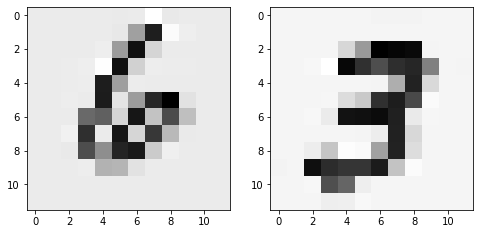

In [8]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
axs[0].imshow(x_train_small[0], cmap='binary')
axs[1].imshow(x_train_3_small[0], cmap='binary')

drop last dimension as its (1,)

In [9]:
x_train_small = x_train_small.reshape(x_train_small.shape[:-1])
x_test_small = x_test_small.reshape(x_test_small.shape[:-1])

x_train_3_small = x_train_3_small.reshape(x_train_3_small.shape[:-1])
x_test_3_small = x_test_3_small.reshape(x_test_3_small.shape[:-1])

reduce the size of the data for faster training:

In [10]:
x_train_small = x_train_small[:4000]
x_train_3_small = x_train_3_small[:4000]
x_test_small = x_test_small[:900]
x_test_3_small = x_test_3_small[:900]

Now we have the following datasets:

In [11]:
print("x_train_small: ", x_train_small.shape)
print("x_test_small: ", x_test_small.shape)
print("x_train_3_small: ", x_train_3_small.shape)
print("x_test_3_small: ", x_test_3_small.shape)

x_train_small:  (4000, 12, 12)
x_test_small:  (900, 12, 12)
x_train_3_small:  (4000, 12, 12)
x_test_3_small:  (900, 12, 12)


## Circuit

Create pennylane device to simulate on. For cpu best fastest is lightning.qubit

In [12]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

Create SQAE model.
Since the input images are 12x12 we split it into 9 4x4 patches. Therfore we use 9 data qubits with kernel_size 4 and stride 4.
The fastest diff method for simulation is adjoint

In [13]:
model = pQAE.ConvSQAE(DATA_QBITS,
                      LATENT_QBITS, 
                      dev1, 
                      INPUT_DATA_SIZE, 
                      kernel_size=4, 
                      stride=4, 
                      DRCs=DRCs, 
                      diff_method="adjoint")

plot the circuit to check

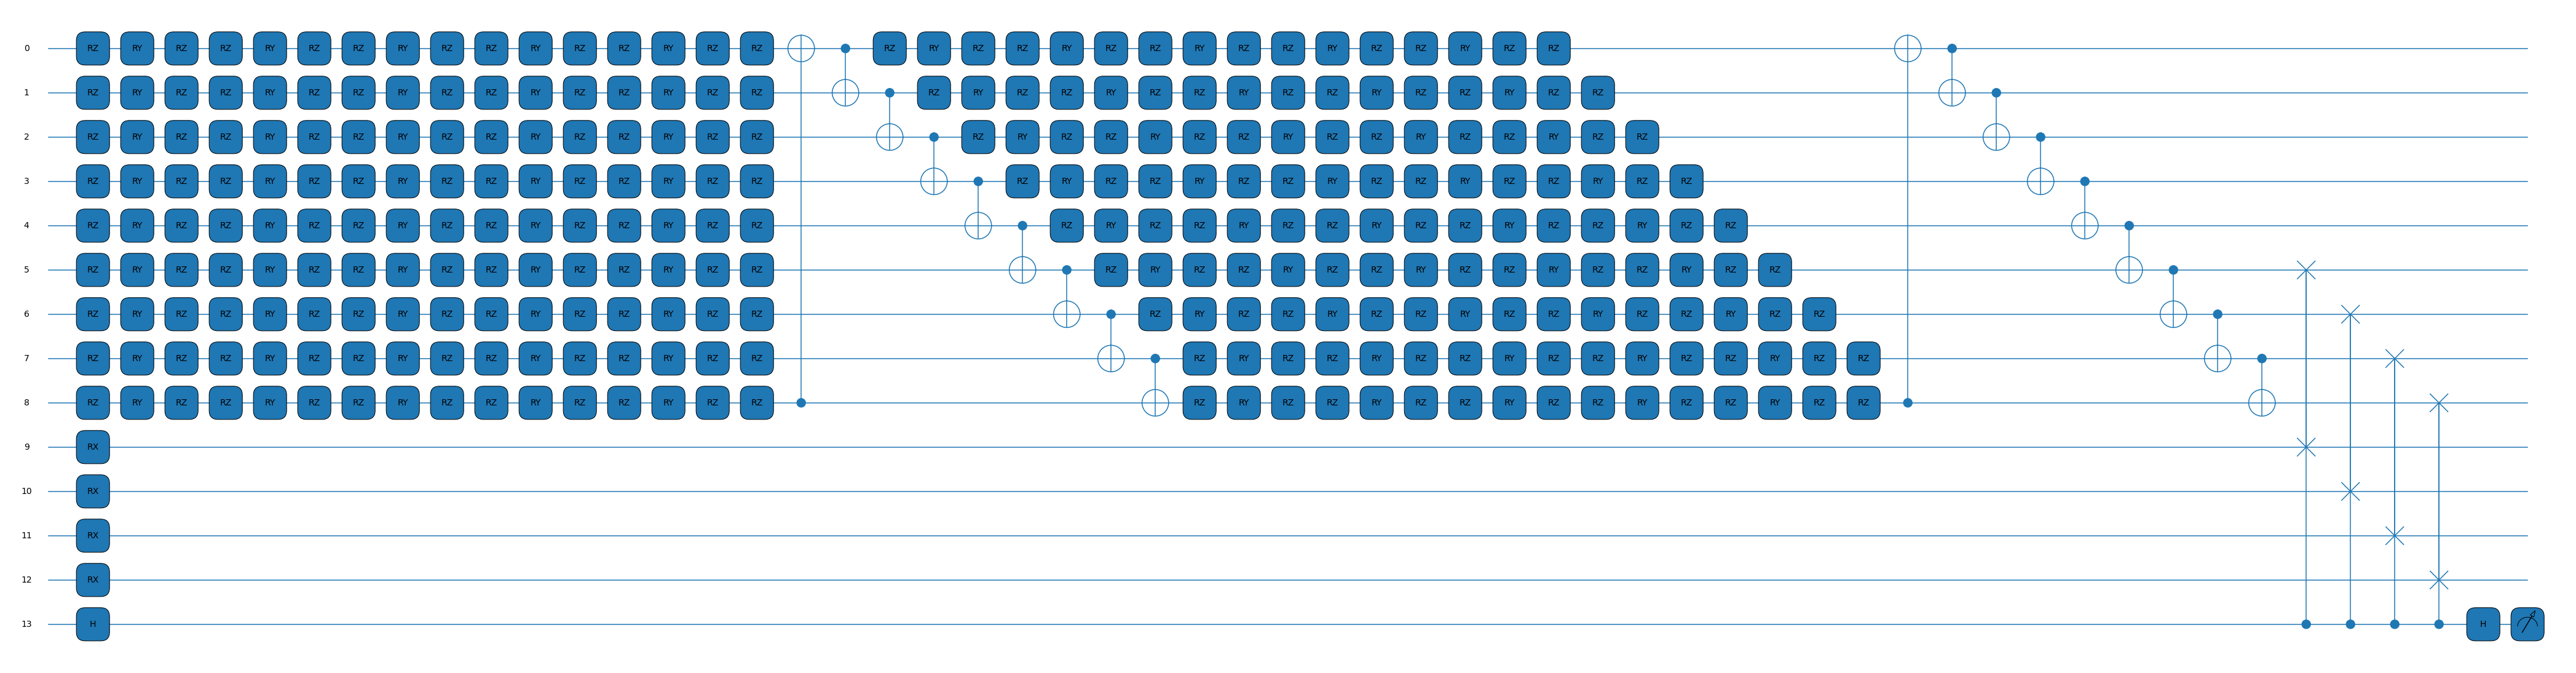

In [14]:
model.plot_circuit()

In [ ]:
model.train(x_train_3_small, x_test_3_small, 
            learning_rate=0.001, 
            epochs=EPOCHS, 
            batch_size=30, 
            print_step_size=50, 
            save_auc=True,
            x_val_signal=x_test_small)

Step: 50      | Loss: 0.84       | avg step time 4.87 | 0.5048446593693341
Step: 100     | Loss: 0.836      | avg step time 7.44 | 0.5017627297756135
____
Epoch: 0     | Loss: 0.81       | Val Loss 0.804
____
Step: 50      | Loss: 0.774      | avg step time 3.95 | 0.49579319975132435
Step: 100     | Loss: 0.772      | avg step time 10.8 | 0.4907727858878933
____
Epoch: 1     | Loss: 0.736      | Val Loss 0.734
____
Step: 50      | Loss: 0.656      | avg step time 4.24 | 0.47883589386150827
Step: 100     | Loss: 0.729      | avg step time 6.2 | 0.4721865749176088
____
Epoch: 2     | Loss: 0.676      | Val Loss 0.656
____
Step: 50      | Loss: 0.6        | avg step time 4.2 | 0.46256981639066513
Step: 100     | Loss: 0.65       | avg step time 7.95 | 0.4573101401418602
____
Epoch: 3     | Loss: 0.645      | Val Loss 0.636
____
Step: 50      | Loss: 0.662      | avg step time 4.14 | 0.44940447395462396
Step: 100     | Loss: 0.635      | avg step time 10.3 | 0.4445849573171736


## Evaluation

We can evaluate the anomaly tagging performance against the sixes and see that we get a good AUC

In [ ]:
model.evaluate(x_test_3_small, x_test_small)

We can also check the how the auc changed during traing

In [ ]:
plt.plot(model.auc_hist)

and of course check the loss history

In [ ]:
model.plot_train_hist(logscale=True)

in addition we can visualize the state of a specific qubit for input data points.
E.g. we can see how the distribution of images of the two different classes look in one of the latent qubits when measuring

In [ ]:
model.plot_latent_space(0,x_test_3_small[:10],x_test_small[:10])